In [1]:
#Mine
import uproot
import pandas as pd
import numpy as np
import boost_histogram as bh
import matplotlib.pyplot as plt
import pickle
# import atlasplots as ap
%matplotlib inline

In [2]:
#John's
import numpy as np
import tensorflow as tf
import os
import time
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import statistics as stat
import ROOT
now = datetime.utcnow().strftime("%y%m%d%H%M%S")

2023-07-17 23:27:47.146056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6fa5c/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-c1d8e/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

Welcome to JupyROOT 6.28/00


In [3]:
import sys
 
# setting path
sys.path.append('..')
 
# importing
import atlasplots as ap

In [4]:
# df_mc20_clean = pickle.load(open('../picklefiles/df_mc20_clean.pickle', 'rb'))



# #converted and unconverted
# df_conv = df_mc20_clean[df_mc20_clean.y_truth_convType == 0]
# df_conv.index = list(range(len(df_conv))) #resetting indicies
# df_unconv = df_mc20_clean[df_mc20_clean.y_truth_convType == 1]
# df_unconv.index = list(range(len(df_unconv))) #resetting indicies

In [5]:
# #SEPARATING EVEN AND ODD

# def evenodd(df_name):
#     '''separates input dataframe df_name into even events and odd events, by index'''
#     evenlist = []
#     oddlist = []
#     for i in range(len(df_name)):
# #         print(i)
#         if i%2 == 0:
#             evenlist.append(i)
#         else:
#             oddlist.append(i)
            
#     even = df_name.loc[evenlist]
#     odd =  df_name.loc[oddlist]
    
#     return even, odd

In [6]:
# df_evenc,df_oddc = evenodd(df_conv)
# df_evenu, df_oddu = evenodd(df_unconv)

# df_evenc

In [7]:
version = 'BACKW100000_preTEST'
converted = False   #False for unconverted, True for converted    ##ACTUALLY FIX THIS TO DO SOMETHING

In [35]:
df_evenc = pickle.load(open('../picklefiles/'+version+'df_mc20_conv_even.pickle', 'rb'))
df_oddc = pickle.load(open('../picklefiles/'+version+'df_mc20_conv_odd.pickle', 'rb'))
# df_evenu = pickle.load(open('../picklefiles/'+version+'df_mc20_unconv_even.pickle', 'rb'))
# df_oddu = pickle.load(open('../picklefiles/'+version+'df_mc20_unconv_odd.pickle', 'rb'))

In [9]:
features_stand = ['HadLeakage_stand', 'y_Reta_stand', 'y_Rphi_stand', 'y_weta2_stand',
                   'y_wtots1_stand', 'y_weta1_stand', 'y_fracs1_stand', 'y_deltae_stand',
                   'y_Eratio_stand', 'y_f1_stand']
features = ['HadLeakage', 'y_Reta', 'y_weta2', 'y_Rphi', 'y_wtots1', 
            'y_weta1', 'y_fracs1', 'y_deltae', 'y_Eratio', 'y_f1']

In [36]:
# FOR NOW just doing **unconv.**  variables
featlist = features_stand   # either features or features_stand 
weightstr = 'finalWeight'   #either 'finalWeight' for E_T and eta weighting or 'goodWeight' for not


# for unconverted. (##add in option to change later)
train_features_even = np.array(df_evenc[featlist])
train_labels_even   = np.array(df_evenc['y_isTruthMatchedPhoton'])
train_weights_even  = np.array(df_evenc[weightstr])
test_features_even = np.array(df_oddc[featlist])
test_labels_even   = np.array(df_oddc['y_isTruthMatchedPhoton'])
test_weights_even  = np.array(df_oddc[weightstr])

train_features_odd = np.array(df_oddc[featlist])
train_labels_odd   = np.array(df_oddc['y_isTruthMatchedPhoton'])
train_weights_odd  = np.array(df_oddc[weightstr])
test_features_odd = np.array(df_evenc[featlist])
test_labels_odd   = np.array(df_evenc['y_isTruthMatchedPhoton'])
test_weights_odd  = np.array(df_evenc[weightstr])


In [37]:
train_features_even.shape


(74574, 10)

In [38]:
np.sum(train_labels_even)/len(train_labels_even), np.sum(test_labels_even)/len(test_labels_even)

(0.6150535039021643, 0.614315981441253)

In [40]:
def train_model(train_features,train_labels,train_weights,valid_features,valid_labels,valid_weights):
    """
    Trains a binary classification model using the provided training and validation data.

    Args:
        train_features (numpy.ndarray): The input features for training the model.
        train_labels (numpy.ndarray): The target labels for training the model.
        train_weights (numpy.ndarray): The sample weights for training the model.
        valid_features (numpy.ndarray): The input features for validating the model.
        valid_labels (numpy.ndarray): The target labels for validating the model.
        valid_weights (numpy.ndarray): The sample weights for validating the model.

    Returns:
        tuple: A tuple containing the trained model and a dictionary of loss and accuracy values during training.

    """

    inputs = tf.keras.layers.Input(dtype=tf.float64,shape=(train_features.shape[1],))
    Dx = inputs
    Dx = tf.keras.layers.BatchNormalization()(Dx)
    Dx = tf.keras.layers.Dense(512,input_shape = (train_features.shape[1],))(Dx)
    Dx = tf.keras.layers.LeakyReLU()(Dx)
    Dx = tf.keras.layers.Dense(512,input_shape = (train_features.shape[1],))(Dx)
    Dx = tf.keras.layers.LeakyReLU()(Dx)
    Dx = tf.keras.layers.Dense(512,input_shape = (train_features.shape[1],))(Dx)
    Dx = tf.keras.layers.Dense(1,activation="sigmoid")(Dx)
    f = tf.keras.models.Model([inputs],[Dx])

    print('Classifier Summary')
    f.summary()

    ###########################################
    # Train model
    ############################################
    f.compile(loss = tf.keras.losses.binary_crossentropy, optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5),metrics=["accuracy"])

    callback_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience = 10)
    callback_nan = tf.keras.callbacks.TerminateOnNaN()

    losses = {"train":[],"accuracy":[],"validation":[]}
    hist = f.fit(x=train_features,
           y=train_labels,
           sample_weight=np.abs(train_weights),
           callbacks=[callback_nan,callback_es],
           batch_size=256,
           epochs=15,
           verbose=1,
           validation_data=(valid_features,valid_labels,np.abs(valid_weights)))
    losses["train"].append(hist.history['loss'])
    losses["accuracy"].append(hist.history['accuracy'])
    losses["validation"].append(hist.history['val_loss'])

    return f,losses

In [41]:
def plot_losses(losses,name,label):
    """
    Plots the training and validation losses over epochs.

    Args:
        losses (dict): A dictionary containing the training and validation losses.
        name (str): The name of the plot file to be saved.
        label (str): The label for the plot.

    Returns:
        None
    """
    train_losses = losses['train']
    validation_losses = losses['validation']
    fig1, ax1 = plt.subplots(1)
    plt.plot(range(len(train_losses[0])), train_losses[0], color="blue",label="Training Loss")
    plt.plot(range(len(validation_losses[0])), validation_losses[0],color="red",label='Validation Loss')
    ax1.legend(loc='upper right')
    ax1.title.set_text(label)
    ax1.text(0.85, 0.77, 'ATLAS Internal', weight='bold',horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    fig1.savefig("plots/"+name+".pdf",bbox_inches='tight')
    plt.clf()
    plt.cla()

In [42]:
def plot_roc(model,test_features,test_labels,name,label):
    """
    Plots the Receiver Operating Characteristic (ROC) curve for a binary classification model.

    Args:
        model (tf.keras.Model): The trained model used for prediction.
        test_features (numpy.ndarray): The input features for testing the model.
        test_labels (numpy.ndarray): The true labels for the test data.
        name (str): The name of the plot file to be saved.
        label (str): The label for the plot.

    Returns:
        None

    Raises:
        None

    """
    y_pred = model.predict(test_features).ravel()

    # Compute the false positive rate, true positive rate, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels,y_pred)

    f,ax = plt.subplots(1)
    plt.plot([1,0],[0,1],'k--')
    plt.plot(1-fpr, tpr)
    plt.xlabel('Bkg Rejection')
    plt.ylabel('Signal Efficiency')
    plt.title(label)
    plt.text(0.85, 0.95, 'ATLAS Internal', weight='bold',horizontalalignment='center', verticalalignment='center')
    #plt.show()
    f.savefig("plots/"+name+".pdf",bbox_inches='tight')
    plt.clf()
    plt.cla()

In [43]:
def validation_plot(model,test_features,train_features,train_labels,test_labels,train_weights,test_weights,name):
    """
    Creates a validation plot comparing the output of a neural network model for signal and background events.

    Args:
        model (tf.keras.Model): The trained model used for prediction.
        test_features (numpy.ndarray): The input features for testing the model.
        train_features (numpy.ndarray): The input features for training the model.
        train_labels (numpy.ndarray): The target labels for training the model.
        test_labels (numpy.ndarray): The target labels for testing the model.
        train_weights (numpy.ndarray): The sample weights for training the model.
        test_weights (numpy.ndarray): The sample weights for testing the model.
        name (str): The name of the plot file to be saved.

    Returns:
        None

    Raises:
        None

    """
    y_pred = model.predict(test_features).ravel()
    y_pred_train = model.predict(train_features).ravel()
    ROOT.gStyle.SetOptStat(0)
    hist_sig = ROOT.TH1F("h_sig",";NN output; Normalized Events",21,0,1.1)
    hist_bkg = ROOT.TH1F("h_bkg",";NN output;Normalized Events",21,0,1.1)
    hist_sig_train = ROOT.TH1F("h_sig_train","NN output;Normalized Events",21,0,1.1)
    hist_bkg_train = ROOT.TH1F("h_bkg_train","NN output;Normalized Events",21,0,1.1)

    for i in range(len(test_features)):
        if (test_labels[i]):
            hist_sig.Fill(y_pred[i],test_weights[i])
        else:
            hist_bkg.Fill(y_pred[i],test_weights[i])

    for i in range(len(train_features)):
        if (train_labels[i]):
            hist_sig_train.Fill(y_pred_train[i],train_weights[i])
        else:
            hist_bkg_train.Fill(y_pred_train[i],train_weights[i])

    can = ROOT.TCanvas("can","can",800,600)

    hist_sig.SetLineColor(1)
    hist_sig.SetFillColor(1)
    hist_sig.SetFillStyle(3005)
    hist_sig.SetMarkerStyle(0)
    hist_bkg.SetLineColor(8)
    hist_bkg.SetFillColor(8)
    hist_bkg.SetMarkerStyle(0)
    hist_sig_train.SetMarkerColor(1)
    hist_sig_train.SetLineColor(1)
    hist_sig_train.SetMarkerSize(1)
    hist_sig_train.SetMarkerStyle(8)
    hist_bkg_train.SetMarkerColor(209)
    hist_bkg_train.SetLineColor(209)
    hist_bkg_train.SetMarkerStyle(8)
    h = hist_bkg.DrawNormalized("HIST E")
    h.SetMinimum(0)
    h.SetMaximum(h.GetMaximum()*3)
    hist_sig.DrawNormalized("HIST SAME E")
    hist_bkg_train.DrawNormalized("pe SAME")
    hist_sig_train.DrawNormalized("pe SAME")
    leg = ROOT.TLegend(0.6,0.6,0.95,0.9)
    leg.SetTextSize(.035)
    leg.AddEntry(hist_sig_train,"MC Signal (train)","pe")
    leg.AddEntry(hist_bkg_train,"MC Background (train)","pe")
    leg.AddEntry(hist_sig,"MC Signal (test)","F")
    leg.AddEntry(hist_bkg,"MC Background (test)","F")
    leg.SetBorderSize(0)
    leg.Draw()
#     ROOT.ATLASLabel(0.2,0.88,"Internal");   
    can.Print("plots/"+name+".pdf")

In [44]:
method = 'train'
outmodel = version+'conv'

In [45]:
#actually using the functions
if method == 'train':
    f_even, losses_even = train_model(train_features_even,train_labels_even,train_weights_even,test_features_even,test_labels_even,test_weights_even)
    f_odd, losses_odd = train_model(train_features_odd,train_labels_odd,train_weights_odd,test_features_odd,test_labels_odd,test_weights_odd)

#     plot_losses(losses_even,outmodel+"_losses_even","Even NN")
#     plot_losses(losses_odd,outmodel+"_losses_odd","Odd NN")
#     plot_roc(f_even,test_features_even,test_labels_even,outmodel+"_roc_even","Even NN")
#     plot_roc(f_odd,test_features_odd,test_labels_odd,outmodel+"_roc_odd","Odd NN")
#     validation_plot(f_even,test_features_even,train_features_even,train_labels_even,test_labels_even,train_weights_even,test_weights_even,outmodel+"_validation_even")
#     validation_plot(f_odd,test_features_odd,train_features_odd,train_labels_odd,test_labels_odd,train_weights_odd,test_weights_odd,outmodel+"_validation_odd")


#     y_pred_even = f_even.predict(test_features_even).ravel()
#     fpr_even, tpr_even, thresholds_even = roc_curve(test_labels_even,y_pred_even)
#     auc_nom_even = auc(fpr_even,tpr_even)

#     y_pred_odd = f_odd.predict(test_features_odd).ravel()
#     fpr_odd, tpr_odd, thresholds_odd = roc_curve(test_labels_odd,y_pred_odd)
#     auc_nom_odd = auc(fpr_odd,tpr_odd)

Classifier Summary
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 batch_normalization_2 (Batc  (None, 10)               40        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 512)               5632      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                        

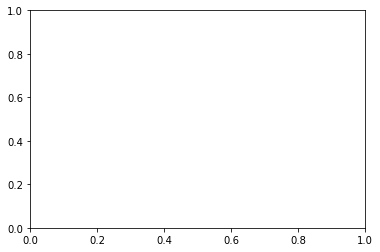

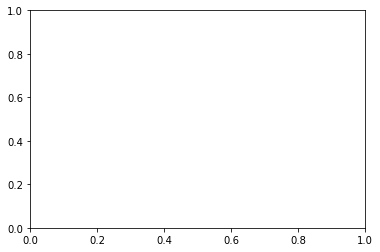

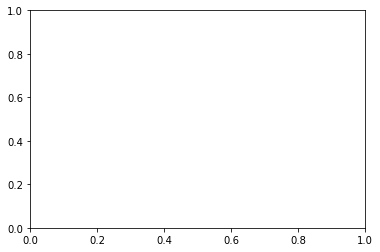

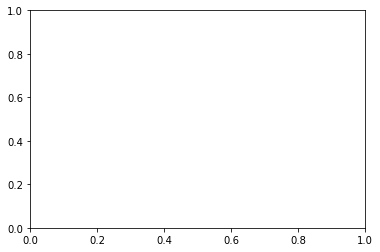

Info in <TCanvas::Print>: pdf file plots/BACKW100000_preTESTconv_validation_even.pdf has been created
Info in <TCanvas::Print>: pdf file plots/BACKW100000_preTESTconv_validation_odd.pdf has been created


In [46]:
plot_losses(losses_even,outmodel+"_losses_even","Even NN")
plot_losses(losses_odd,outmodel+"_losses_odd","Odd NN")
plot_roc(f_even,test_features_even,test_labels_even,outmodel+"_roc_even","Even NN")
plot_roc(f_odd,test_features_odd,test_labels_odd,outmodel+"_roc_odd","Odd NN")
validation_plot(f_even,test_features_even,train_features_even,train_labels_even,test_labels_even,train_weights_even,test_weights_even,outmodel+"_validation_even")
validation_plot(f_odd,test_features_odd,train_features_odd,train_labels_odd,test_labels_odd,train_weights_odd,test_weights_odd,outmodel+"_validation_odd")


y_pred_even = f_even.predict(test_features_even).ravel()
fpr_even, tpr_even, thresholds_even = roc_curve(test_labels_even,y_pred_even)
auc_nom_even = auc(fpr_even,tpr_even)

y_pred_odd = f_odd.predict(test_features_odd).ravel()
fpr_odd, tpr_odd, thresholds_odd = roc_curve(test_labels_odd,y_pred_odd)
auc_nom_odd = auc(fpr_odd,tpr_odd)

In [47]:
datafile = version+'conv. test nonstand'
#####################################################
# Save model 
#####################################################
model_json_classif_even = f_even.to_json()
with open("./models/fclass_"+outmodel+"_even.json", "w") as json_file:
    json_file.write(model_json_classif_even)
f_even.save_weights("./models/fclass_"+outmodel+"_even.h5")
np.savez("./models/losses_"+outmodel+"_even.npz",losses=losses_even)

model_json_classif_odd = f_odd.to_json()
with open("./models/fclass_"+outmodel+"_odd.json", "w") as json_file:
    json_file.write(model_json_classif_odd)
f_odd.save_weights("./models/fclass_"+outmodel+"_odd.h5")
np.savez("./models/losses_"+outmodel+"_odd.npz",losses=losses_odd)

print("EVEN AUC: "+str(auc_nom_even))
print("ODD AUC: "+str(auc_nom_odd))
print("Saved model to disk")
print("Saved model timestamp: models/fclass_"+outmodel)
print("Trained on data: "+datafile)
print("Saved loss: models/losses_"+outmodel+".npz")

EVEN AUC: 0.9689010538033156
ODD AUC: 0.8940487252377985
Saved model to disk
Saved model timestamp: models/fclass_BACKW100000_preTESTconv
Trained on data: BACKW100000_preTESTconv. test nonstand
Saved loss: models/losses_BACKW100000_preTESTconv.npz


In [23]:
##seeing what a naive prediction would give:
np.sum(train_labels_even)/len(train_labels_even), np.sum(test_labels_even)/len(test_labels_even)

(0.8674902036584723, 0.8675593276926997)

In [32]:
np.sum(np.multiply(train_labels_even*1,train_weights_even))/np.sum(train_weights_even)

0.5000000000000002